This notebook has a collection of helper functions for exploring a benchmarking result against SMaHT MIMS.

The recommended truvari parameters and conversion of the truvari result into a dataframe is:

```bash
truvari bench -p 0.9 -P 0.9 --passonly --pick multi \
    --includebed $bed -b $base -c $comp \
    -o ${name}_result/
truvari vcf2df -i -f -b ${name}_result/ ${name}_result/data.jl
```

The resultant `data.jl` can be input here.

In [1]:
import joblib
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import truvari
from scipy.stats import pearsonr

In [248]:
def size_type_metrics(df):
    """
    Makes a dataframe of precision/recall/f1 by sv type and size
    """
    rows = []
    for i, sub in df.groupby(['szbin', 'svtype']):
        cnts = sub['state'].value_counts()
        rows.append((*i, * truvari.performance_metrics(**cnts)))
    return pd.DataFrame(rows, columns=['szbin', 'svtype', 'precision', 'recall', 'f1'])

def size_type_barplot(metrics, y="recall", title="Size/Type Performance"):
    """
    Simple barplot of y=recall/precision/f1 by svsize hue svtype
    metrics = output from `size_type_metrics`
    Returns a seaborn plot
    """
    p = sb.barplot(data=metrics, x='szbin', y=y, hue='svtype')
    p.set(title=title, xlabel="SizeBin")
    _ = plt.xticks(rotation=45, ha='right')
    return p

def split_base_comp(df):
    """
    Separates dataframe rows into those from the baseline and from the comparison VCF.
    Extracts Truvari's MatchId annotation so the subsets have a key to potentially joine one another
    """
    # Separate out the variants from the base VCF and add new columns of the base/comp ids
    base = data[data['state'].isin(['tpbase', 'fn'])].copy()
    base['base_id'] = base['MatchId'].apply(lambda x: x[0])
    base['comp_id'] = base['MatchId'].apply(lambda x: x[1])

    # Separate out the variants from the comparison VCF and add new columns of the base/comp ids
    comp = data[data['state'].isin(['tp', 'fp'])].copy()
    comp['base_id'] = comp['MatchId'].apply(lambda x: x[0])
    comp['comp_id'] = comp['MatchId'].apply(lambda x: x[1])
    return base, comp

def sniffles_vaf(df, sample):
    """
    Calculate sniffles' predicted vaf
    """
    dv = df[f'{sample}_DV']
    dr = df[f'{sample}_DR']
    tot = dv + dr
    return dv / tot

def sawfish_vaf(df, sample):
    """
    Calculate sawfish' predicted vaf
    """
    dr = df[f'{sample}_AD_ref']
    dv = df[f'{sample}_AD_alt']
    tot = dr + dv
    return dv / (dv+dr)

def svdss_vaf(df, sample):
    """
    Calculate sawfish' predicted vaf
    """
    return df['WEIGHT'] / df['COV']

tool_vaf = {'sniffles': sniffles_vaf,
            'svdss': svdss_vaf,
            'sawfish': sawfish_vaf}

def get_predicted_vaf(comp, sample="", tool=None):
    """
    Calculate the predicted_vaf annotation for a dataframe 
    Supported tools: svdss, sniffles, sawfish
    """
    if tool not in tool_vaf.keys():
        raise Exception(f"Unexpected tool name {tool}")
    return tool_vaf[tool](comp, sample)

def get_vaf_bin(vaf, bins=[0, 0.05, 0.3, 0.7, 1], labels=["Ultra-Low", "Low", "Medium", "High"]):
    """
    Bin VAFs and apply labels
    """
    return pd.cut(vaf, bins=bins, labels=labels) 

def fill_in_vafs(base, comp):
    """
    Sets predicted and expected vaf columns for base and comp dataframes
    """
    sum_vaf = base[base['state'] == 'tpbase'].groupby(['comp_id'])['expected_vaf'].sum()
    a = comp[(comp['state'] == 'tp') & ~comp['comp_id'].isin(sum_vaf.index)][['base_id', 'comp_id']].copy()
    b = base[base['base_id'].isin(a['base_id'])]
    a.set_index('base_id', inplace=True)
    b.set_index('base_id', inplace=True)
    a['expected_vaf'] = b['expected_vaf']
    a = a.reset_index(drop=True).set_index('comp_id')
    sum_vaf = pd.concat([sum_vaf, a])

    comp.set_index('comp_id', inplace=True)
    comp['expected_vaf'] = sum_vaf.where(sum_vaf <= 1, 1)
    comp.reset_index(inplace=True)

    sum_vaf = comp[comp['state'] == 'tp'].groupby(['base_id'])['predicted_vaf'].sum()
    a = base[(base['state'] == 'tpbase') & ~base['base_id'].isin(sum_vaf.index)][['base_id', 'comp_id']].copy()
    b = comp[comp['comp_id'].isin(a['comp_id'])]
    a.set_index('comp_id', inplace=True)
    b.set_index('comp_id', inplace=True)

    a['predicted_vaf'] = b['predicted_vaf']
    a = a.reset_index(drop=True).set_index('base_id')
    sum_vaf = pd.concat([sum_vaf, a])

    base.set_index('base_id', inplace=True)
    base['predicted_vaf'] = sum_vaf.where(sum_vaf <= 1, 1)
    base.reset_index(inplace=True)

def vaf_performance(predicted, expected):
    """
    Summarize the difference of predicted and expected vaf
    Returns a DataFrame with the description of the predicted-expected distribution
    As well as PearsonR coefficient and Pval, and mean-square error (MSE)
    """
    o1 = (predicted - expected).describe().to_frame()
    o2 = pearsonr(predicted, expected)
    o1.loc["PearsonR"] = o2.statistic
    o1.loc["Pval"] = o2.pvalue

    MSE = ((predicted - expected) ** 2).sum()  / len(predicted)
    o1.loc['MSE'] = MSE
    return o1

def comp_add_base_anno(comp, base):
    """
    Add the NumNeighbors and TRF annotations from base to the comp dataframe
    Edits them in place
    """
    comp.set_index('base_id', inplace=True)
    base.set_index('base_id', inplace=True)

    comp['NumNeighbors'] = base['NumNeighbors']
    comp['TRF'] = base['TRF']
    comp.reset_index(inplace=True)
    base.reset_index(inplace=True)

    
def make_mosaic_df(base, comp):
    """
    Given a truvari vcf2df dataframe
    Unite the predicted/expected vaf and baseline specific annotations 
    Returns a new, cleaned up datafraome
    """
    base['expected_vaf'] = base['VAF_alt']

    fill_in_vafs(base, comp)
    comp_add_base_anno(comp, base)

    columns = ['svtype', 'svlen', 'szbin', 'TRF', 'NumNeighbors', 'expected_vaf', 'predicted_vaf', 'state']

    base = base[columns]
    comp = comp[columns]

    data = pd.concat([base, comp])

    data['expected_vaf_bin'] = get_vaf_bin(data['expected_vaf'])
    data['predicted_vaf_bin'] = get_vaf_bin(data['predicted_vaf'])
    data['matching_vaf_bin'] = data['expected_vaf_bin'] == data['predicted_vaf_bin']
    data['vaf-delta'] = data['predicted_vaf'] - data['expected_vaf']
    return data

# Expected SUM VAF

It's possible that a variant caller has make a single 'consensus' call that is the representation of multiple highly similar baseline variants. For example, the benchmark may have a 100bp and 102bp deletion. However, a caller may not be able to distinguish the 2bp difference from sequencing error and will report a single 101bp deletion. `truvari bench --pick multi` allows the two baseline deletions to match to the single comparison deletion. Therefore, we must alter the baseline's expected VAF to be the sum of the two deletions. This will allow the caller's 'consensus' variant's predicted VAF to more accurately reflect the expected VAF.

In [251]:
data = joblib.load("../smaht/example_bench/merge381sawfish_result/data.jl")
base, comp = split_base_comp(data)
# we have to set the predicted_vaf based on annotations in comparison VCF
comp['predicted_vaf'] = get_predicted_vaf(comp, "SMACUIX7SY21", "sawfish")

# Now, we can recombine and simplify the annotations
data = make_mosaic_df(base, comp)

# And I find it's generally easier to analyze the baseline and comparison independently
is_base = data['state'].isin(['tpbase', 'fn'])
base = data[is_base]
comp = data[~is_base]

<Axes: xlabel='vaf-delta', ylabel='Count'>

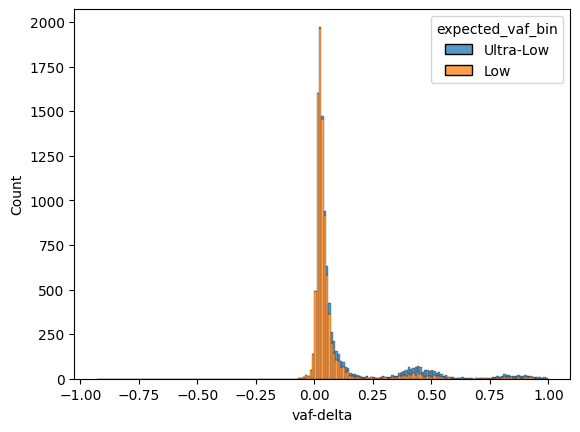

In [259]:
sb.histplot(data=comp[comp['state'] == 'tp'], x='vaf-delta', 
            hue='expected_vaf_bin', 
            multiple='stack', binwidth=0.01,
           hue_order=['Ultra-Low', 'Low'])

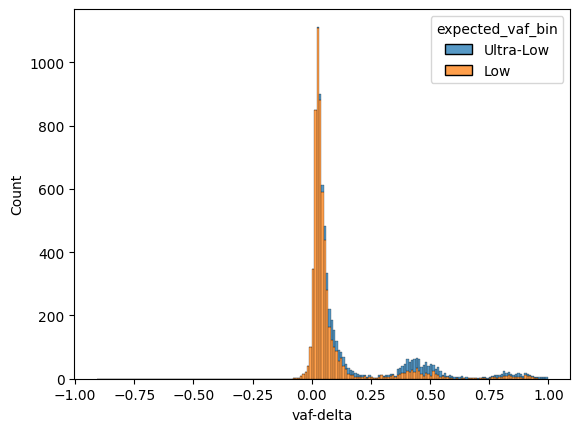

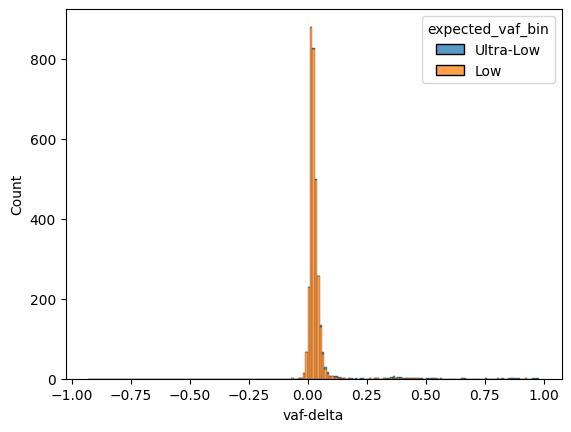

In [272]:
sb.histplot(data=comp[(comp['state'] == 'tp') & (comp['NumNeighbors'] >= 1)].reset_index(), 
            x='vaf-delta', 
            hue='expected_vaf_bin', 
            multiple='stack', binwidth=0.01,
           hue_order=['Ultra-Low', 'Low'])
plt.show()
sb.histplot(data=comp[(comp['state'] == 'tp') & (comp['NumNeighbors'] == 0)].reset_index(), 
            x='vaf-delta', 
            hue='expected_vaf_bin', 
            multiple='stack', binwidth=0.01,
           hue_order=['Ultra-Low', 'Low'])
plt.show()

<Axes: xlabel='peVAF-delta', ylabel='Count'>

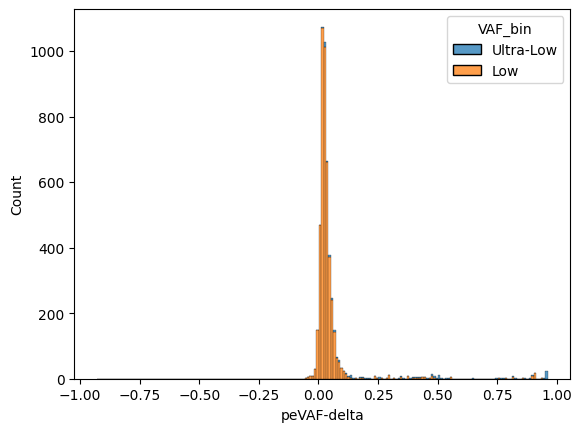

In [81]:
sb.histplot(data=comp[(comp['state'] == 'tp') & (comp['TRF']!=True)].reset_index(), 
            x='peVAF-delta', 
            hue='VAF_bin', 
            multiple='stack', binwidth=0.01,
           hue_order=['Ultra-Low', 'Low'])

<Axes: xlabel='peVAF-delta', ylabel='Count'>

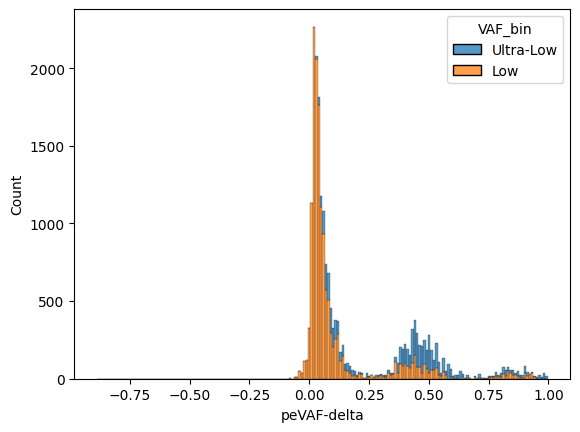

In [79]:
sb.histplot(data=comp[(comp['state'] == 'tp') & comp['TRF']].reset_index(), 
            x='peVAF-delta', 
            hue='VAF_bin', 
            multiple='stack', binwidth=0.01,
           hue_order=['Ultra-Low', 'Low'])

In [63]:
view = comp[comp['state'] == 'tp']
vaf_performance(view['predicted_vaf'], view['expected_vaf'])

,0
count,82357.000000
mean,0.054974
std,0.181140
min,-0.929268
25%,-0.012078
50%,0.018459
75%,0.066891
max,0.997500
PearsonR,0.833095
Pval,0.000000


In [67]:
parts = []
for i in range(0, 4):
    view2 = view[view['NumNeighbors'] == i]
    parts.append(vaf_performance(view2['predicted_vaf'], view2['expected_vaf']))
view2 = view[view['NumNeighbors'] >= 4]
parts.append(vaf_performance(view2['predicted_vaf'], view2['expected_vaf']))
out = pd.concat(parts, axis=1)    
out.columns = ['Isolated', '1', '2', '3', '4+']
out

,Isolated,1,2,3,4+
count,8328.000000,6358.000000,6457.000000,6014.000000,55117.000000
mean,0.005597,0.019130,0.029936,0.037991,0.071426
std,0.075469,0.117326,0.128601,0.149249,0.202531
min,-0.480714,-0.887439,-0.748252,-0.903114,-0.907505
25%,-0.022859,-0.018394,-0.013994,-0.011386,-0.008923
50%,0.002500,0.005843,0.007310,0.011104,0.029383
75%,0.024141,0.029199,0.036868,0.041361,0.093529
max,0.980854,0.990000,0.987732,0.975049,0.997500
PearsonR,0.975942,0.940211,0.929123,0.903622,0.770355
Pval,0.000000,0.000000,0.000000,0.000000,0.000000


In [93]:
# Can I make a 'squared off' dataframe? 
# recombining base and comp, giving them identical columns
# I think just getting predicted_VAF back into base is all I really need to do.
# Or, do I need to just not worry about it so much 
# It sucks to do base and comp filtering twice.. but like, fine.

Index(['chrom', 'start', 'end', 'id', 'svtype', 'svlen', 'szbin', 'qual',
       'filter', 'is_pass', 'AN', 'AC', 'NS', 'AC_Hom', 'AC_Het', 'AC_Hemi',
       'AF', 'MAF', 'HWE', 'ExcHet', 'VAF_ref', 'VAF_alt', 'TRF', 'TRFdiff',
       'TRFrepeat', 'TRFovl', 'TRFstart', 'TRFend', 'TRFperiod', 'TRFcopies',
       'TRFscore', 'TRFentropy', 'TRFsim', 'NumNeighbors', 'NeighId',
       'TruScore', 'PctSeqSimilarity', 'PctSizeSimilarity', 'PctRecOverlap',
       'StartDistance', 'EndDistance', 'SizeDiff', 'GTMatch', 'MatchId',
       'Multi', 'HG002_GT', 'HG00438_GT', 'HG005_GT', 'HG02257_GT',
       'HG02486_GT', 'HG02622_GT', 'state', 'END', 'EVENT', 'EVENTTYPE',
       'HOMLEN', 'HOMSEQ', 'IMPRECISE', 'INSLEN', 'INSSEQ', 'MATEID', 'SVLEN',
       'SVTYPE', 'predicted_VAF', 'SMACUIX7SY21_GT', 'SMACUIX7SY21_GQ',
       'SMACUIX7SY21_PL_ref', 'SMACUIX7SY21_PL_het', 'SMACUIX7SY21_PL_hom',
       'SMACUIX7SY21_AD_ref', 'SMACUIX7SY21_AD_alt', 'SMACUIX7SY21_PS',
       'base_id', 'comp_id'],
    

In [88]:
b['state'].value_counts()[['tpbase', 'fn']]

state
tpbase    8326
fn        7397
Name: count, dtype: int64

In [100]:
x = get_exp_sum_vaf(comp, base)

ValueError: cannot reindex on an axis with duplicate labels

In [101]:
x

In [99]:
b, c = dual_subset(base, comp, lambda x: x['NumNeighbors'] == 0)
recalc_performance(b, c)

(0.9896976184104896, 0.49993995436531763, 0.6643084079325519)

In [91]:
b = base[base['NumNeighbors'] != 0]
c = comp[comp['NumNeighbors'] != 0]
recalc_performance(b, c)

(0.7920680851063829, 0.37359643259068714, 0.5077169399464946)

<Axes: xlabel='index', ylabel='MSE'>

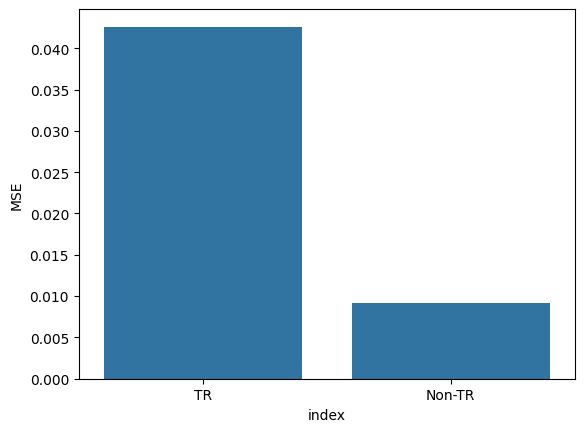

In [77]:
view = comp[comp['state'] == 'tp']
parts = []
for i in [True, False]:
    view2 = view[view['TRF'] == i]
    parts.append(vaf_performance(view2['predicted_vaf'], view2['expected_vaf']))
out2 = pd.concat(parts, axis=1)    
out2.columns = ['TR', 'Non-TR']
out2

view = out2.T.reset_index()
sb.barplot(data=view, x='index', y='MSE')

<Axes: xlabel='TRF', ylabel='NumNeighbors'>

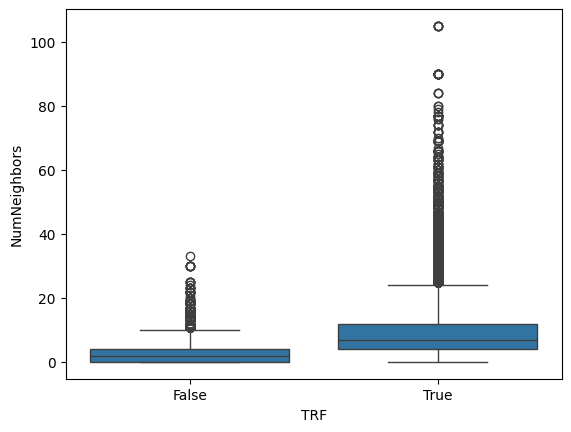

In [78]:
sb.boxplot(data=comp[comp['state'] == 'tp'], x='TRF', y='NumNeighbors')

# Baseline VAF stratify

In [5]:
# Separate out the variants from the base VCF and add new columns of the base/comp ids
base = hifi_data[hifi_data['state'].isin(['tpbase', 'fn'])].copy()
base['base_id'] = base['MatchId'].apply(lambda x: x[0])
base['comp_id'] = base['MatchId'].apply(lambda x: x[1])

# Separate out the variants from the comparison VCF and add new columns of the base/comp ids
comp = hifi_data[hifi_data['state'].isin(['tp', 'fp'])].copy()
comp['base_id'] = comp['MatchId'].apply(lambda x: x[0])
comp['comp_id'] = comp['MatchId'].apply(lambda x: x[1])

/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


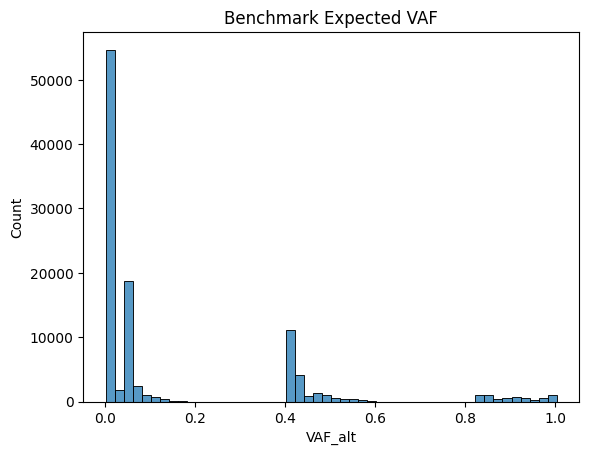

In [6]:
p = sb.histplot(data=base, x="VAF_alt", binwidth=0.02)
_ = p.set(title="Benchmark Expected VAF")

/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1057: Futu

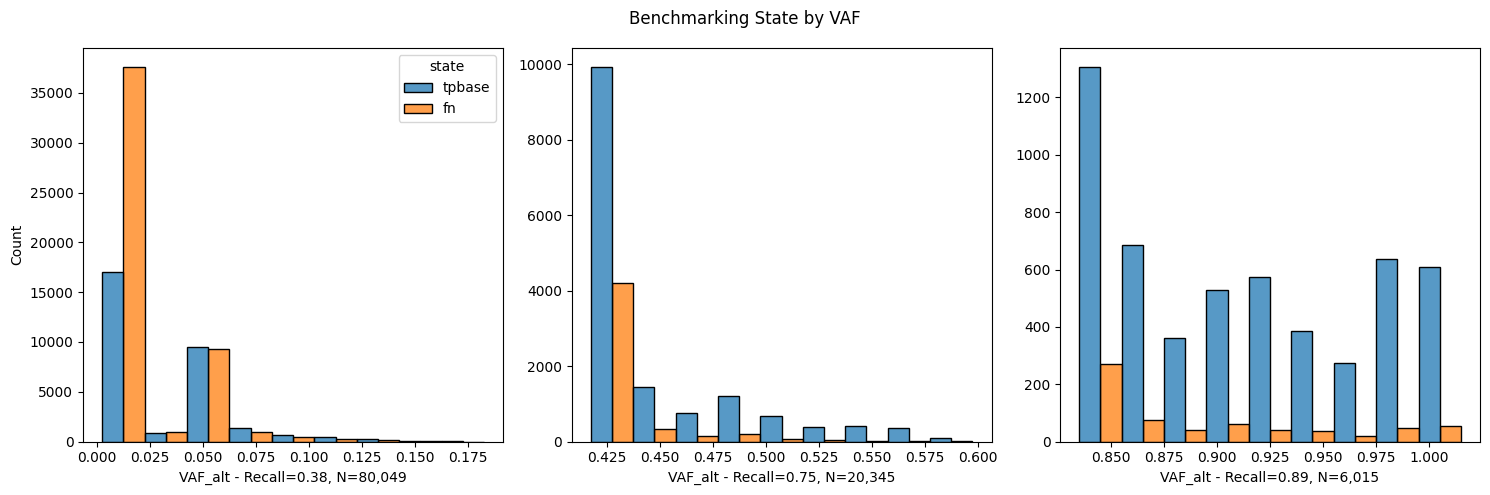

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

view = base[base['VAF_alt'] < 0.30]
p = sb.histplot(data=view, 
                ax=axes[0], 
                x="VAF_alt", 
                hue="state", 
                hue_order=['tpbase', 'fn'], 
                multiple='dodge', 
                binwidth=0.02)
cnt = len(view)
recall = (view['state'] == 'tpbase').sum() / cnt
p.set(xlabel=f"VAF_alt - Recall={recall:.2f}, N={cnt:,}")

view = base[base['VAF_alt'].between(0.30, 0.70)]
p = sb.histplot(data=view,
                ax=axes[1], 
                x="VAF_alt", 
                hue="state", 
                hue_order=['tpbase', 'fn'], 
                multiple='dodge', 
                binwidth=0.02)
axes[1].legend().remove()
cnt = len(view)
recall = (view['state'] == 'tpbase').sum() / cnt
p.set(xlabel=f"VAF_alt - Recall={recall:.2f}, N={cnt:,}", ylabel="")

view = base[base['VAF_alt'] > 0.70]
p = sb.histplot(data=view,
                ax=axes[2], 
                x="VAF_alt", 
                hue="state", 
                hue_order=['tpbase', 'fn'], 
                multiple='dodge', binwidth=0.02)
axes[2].legend().remove()
cnt = len(view)
recall = (view['state'] == 'tpbase').sum() / cnt
p.set(xlabel=f"VAF_alt - Recall={recall:.2f}, N={cnt:,}", ylabel="")

fig.suptitle("Benchmarking State by VAF")
plt.tight_layout()


# MOSAIC
Does that really help anything?

In [8]:
parts = []
low_maf = base[base['VAF_alt'] < 0.30]
parts.append(comp[comp['base_id'].isin(low_maf['comp_id'])]['MOSAIC'].value_counts())

med_maf = base[base['VAF_alt'].between(0.30, 0.70)]
parts.append(comp[comp['comp_id'].isin(med_maf['comp_id'])]['MOSAIC'].value_counts())

high_maf = base[base['VAF_alt'] > 0.70]
parts.append(comp[comp['comp_id'].isin(high_maf['comp_id'])]['MOSAIC'].value_counts())

mosaic = pd.concat(parts, axis=1)
mosaic.columns = ['low', 'medium', 'high']
mosaic.loc['Percent']  = mosaic.iloc[0] / mosaic.sum(axis=0)
mosaic

,low,medium,high
MOSAIC,,,
True,8155.000000,493.000000,82.000000
False,6069.000000,14274.000000,5606.000000
Percent,0.573327,0.033385,0.014416


# 1-to-1 

Find variants that have a single baseline and single comparison match. 

What proportion of the TPs is it?

/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


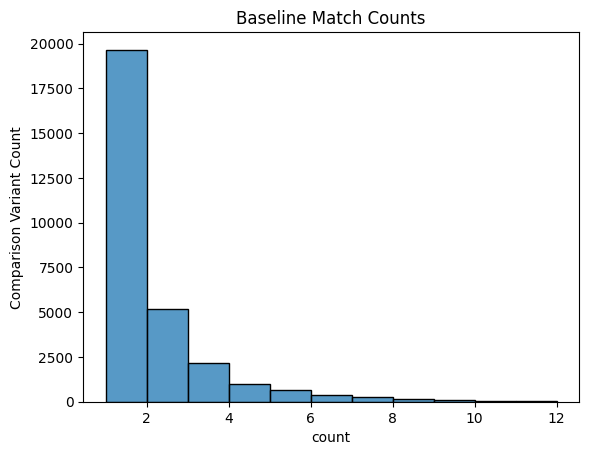

In [147]:
b_cnts = base[base['state'] == 'tpbase']['comp_id'].value_counts()
p = sb.histplot(b_cnts, binwidth=1)
_ = p.set(title="Baseline Match Counts", ylabel="Comparison Variant Count")

In [148]:
(b_cnts == 1).sum() / len(b_cnts)

0.6639529777387427

/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


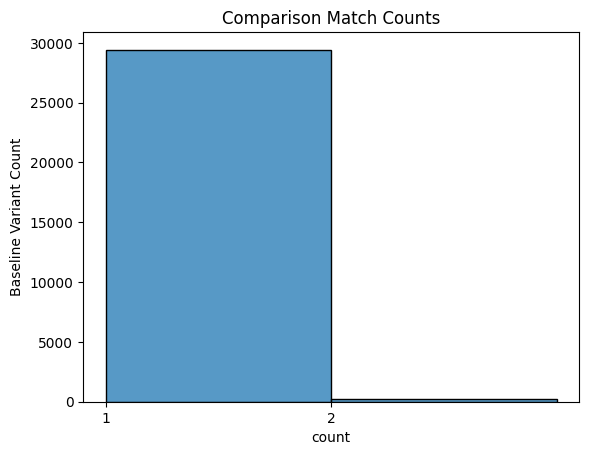

In [149]:
c_cnts = comp[comp['state'] == 'tp']['base_id'].value_counts()
p = sb.histplot(c_cnts, binwidth=1)
plt.xticks([1,2])
_ = p.set(title="Comparison Match Counts", ylabel="Baseline Variant Count")

In [150]:
(c_cnts == 1).sum() / len(c_cnts)

0.9934834723300807

In [155]:
comp['predicted_vaf'] = comp['SAMPLE_DV'] / (comp['SAMPLE_DR'] + comp['SAMPLE_DV'])

/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1057: Futu

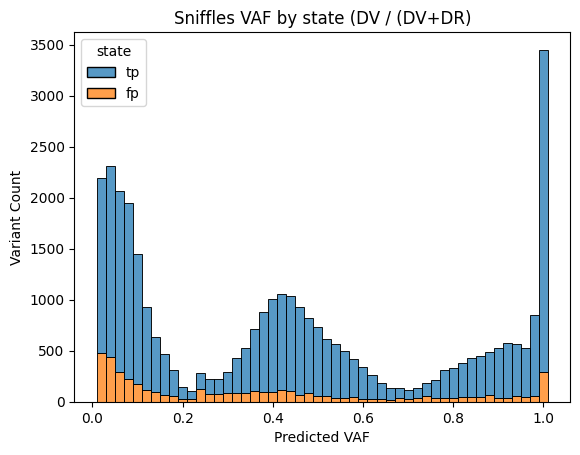

In [168]:
p = sb.histplot(data=comp, x='predicted_vaf', hue='state', multiple='stack', hue_order=['tp', 'fp'], binwidth=0.02)
_ = p.set(xlabel="Predicted VAF", ylabel="Variant Count", title="Sniffles VAF by state (DV / (DV+DR)")

/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


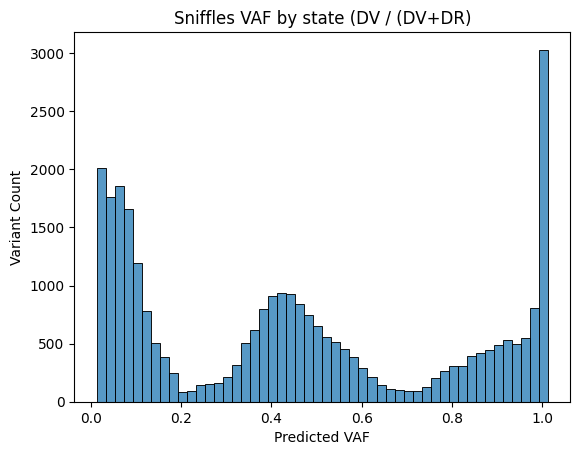

In [186]:
p = sb.histplot(data=comp[comp['state'] == 'tp'], x='predicted_vaf', multiple='stack', hue_order=['tp', 'fp'], binwidth=0.02)
_ = p.set(xlabel="Predicted VAF", ylabel="Variant Count", title="Sniffles VAF by state (DV / (DV+DR)")

/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1057: Futu

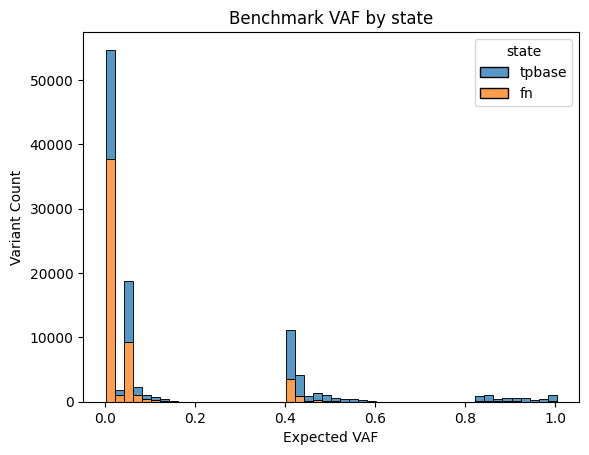

In [169]:
p = sb.histplot(data=base, x='VAF_alt', hue='state', multiple='stack', hue_order=['tpbase', 'fn'], binwidth=0.02)
_ = p.set(xlabel="Expected VAF", ylabel="Variant Count", title="Benchmark VAF by state")

# Expected SUM VAF

In [199]:
sum_vaf = base[base['state'] == 'tpbase'].groupby(['comp_id'])['VAF_alt'].sum()

/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


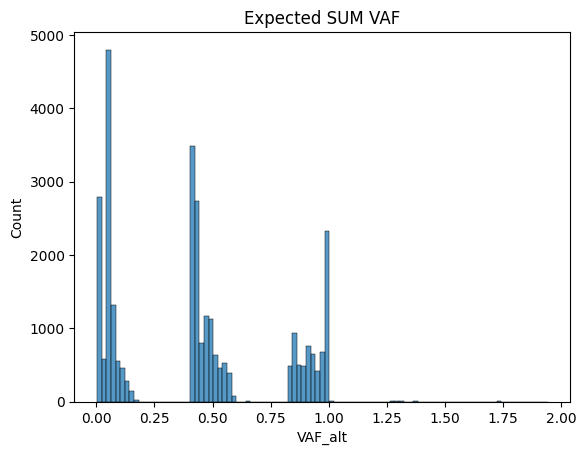

In [190]:
p = sb.histplot(sum_vaf, binwidth=0.02)
_ = p.set(title="Expected SUM VAF")

In [202]:
sum_vaf[sum_vaf > 1]

comp_id
10677.1    1.0375
14790.2    1.3950
15771.0    1.0000
16069.1    1.2950
16241.1    1.1000
19276.7    1.2875
19828.3    1.3675
19854.2    1.2625
20255.0    1.3125
23166.0    1.9350
23553.0    1.7050
23681.0    1.2675
25885.3    1.2750
28014.2    1.6800
28066.1    1.7400
30133.1    1.8400
30163.3    1.2675
30163.4    1.3475
30289.0    1.2675
32672.5    1.3200
34396.0    1.0150
4162.0     1.7400
5416.0     1.0575
7195.0     1.3750
9119.0     1.3775
9275.1     1.0200
9296.2     1.4375
Name: VAF_alt, dtype: float32

In [201]:
sum_vaf.loc["19609.3"]

0.42

In [203]:
comp[comp['comp_id'].isin(sum_vaf[sum_vaf > 1].index)].sample(3)

,chrom,start,end,id,svtype,svlen,szbin,qual,filter,is_pass,...,NM,PHASE,SAMPLE_GT,SAMPLE_GQ,SAMPLE_DR,SAMPLE_DV,SAMPLE_ID,base_id,comp_id,predicted_vaf
hash,,,,,,,,,,,,,,,,,,,,,
fad2faf1d620a24be9eaa3da3dc443b7edcf8c4a,chr8,143661474,143661475,Sniffles2.INS.74DS7,INS,104,"[100,200)",60,[PASS],True,...,None,None,"(1, 1)",60.0,8.0,74.0,None,34396.2,34396.0,0.902439
d63844ba59a4f4aa34618d0524030617773e25a7,chr4,1316970,1316971,Sniffles2.INS.59S3,INS,72,"[50,100)",60,[PASS],True,...,None,None,"(0, 1)",60.0,33.0,23.0,None,23681.0,23681.0,0.410714
38e5213b62ecf5acf982e952c778d6d21fb90db4,chr12,85879216,85879217,Sniffles2.INS.3F5SB,INS,124,"[100,200)",60,[PASS],True,...,None,None,"(1, 1)",60.0,0.0,120.0,None,7195.0,7195.0,1.000000


In [211]:
cview = comp[comp['comp_id'] == "34396.0"][["chrom", "start", "end", "svtype", "svlen", "szbin", "VAF_alt", 'state', 'SAMPLE_GT', 'SAMPLE_DR', 'SAMPLE_DV']]
cview

,chrom,start,end,svtype,svlen,szbin,VAF_alt,state,SAMPLE_GT,SAMPLE_DR,SAMPLE_DV
hash,,,,,,,,,,,
fad2faf1d620a24be9eaa3da3dc443b7edcf8c4a,chr8,143661474,143661475,INS,104,"[100,200)",NaN,tp,"(1, 1)",8.0,74.0


In [214]:
bview = base[(base['comp_id'] == "34396.0")][["chrom", "start", "end", "svtype", "svlen", "szbin", "VAF_alt", 'state'] + [_ for _ in base.columns if _.endswith('_GT')]]
bview[bview['svlen'] >= 100]

,chrom,start,end,svtype,svlen,szbin,VAF_alt,state,HG002_GT,HG00438_GT,HG005_GT,HG02257_GT,HG02486_GT,HG02622_GT,SAMPLE_GT
hash,,,,,,,,,,,,,,,
153de4d0e2dc31bcd16a74ea5a720047086d34fb,chr8,143661421,143661422,INS,104,"[100,200)",0.010,tpbase,"(0, 0)","(0, 0)","(0, 0)","(0, 0)","(0, 1)","(0, 0)",NaN
cd8ef14cb1f126ca067c0deb8945320bc81fbf57,chr8,143661473,143661474,INS,104,"[100,200)",0.835,tpbase,"(0, 0)","(0, 0)","(1, 1)","(0, 0)","(0, 0)","(0, 0)",NaN
97d15a8ca6370ef95c0ba1486882d095a9c66eaa,chr8,143661473,143661474,INS,107,"[100,200)",0.060,tpbase,"(0, 0)","(0, 0)","(0, 0)","(0, 0)","(1, 0)","(1, 0)",NaN
99360aa0ff8759476b09998ac6d4dfe17ce58034,chr8,143661552,143661553,INS,107,"[100,200)",0.050,tpbase,"(0, 0)","(0, 0)","(0, 0)","(0, 0)","(0, 0)","(0, 1)",NaN
dfa9580ffcc48b9e9e30c134ce0b75fc1e59ebce,chr8,143661611,143661612,INS,107,"[100,200)",0.060,tpbase,"(0, 0)","(0, 0)","(0, 0)","(0, 0)","(1, 0)","(1, 0)",NaN
888f01602af2515d45fade4e7288fe7f445560bd,chr8,143661421,143661526,DEL,104,"[100,200)",0.010,fn,"(0, 0)","(0, 0)","(0, 0)","(0, 1)","(0, 0)","(0, 0)",NaN
7adb8a894b05a0c153560174136b8ad0851aedce,chr8,143661664,143661665,INS,164,"[100,200)",0.010,fn,"(0, 0)","(0, 0)","(0, 0)","(1, 0)","(0, 0)","(0, 0)",NaN
252bafd631382d31c15292a71461b7d775808089,chr8,143661667,143661769,DEL,101,"[100,200)",0.010,fn,"(0, 0)","(0, 0)","(0, 0)","(0, 1)","(0, 0)","(0, 0)",NaN
3fef36808cb71d0c6947a6dd6778e989f0787f71,chr8,143661820,143661821,INS,156,"[100,200)",0.010,fn,"(1, 0)","(0, 0)","(0, 0)","(0, 0)","(0, 0)","(0, 0)",NaN


/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


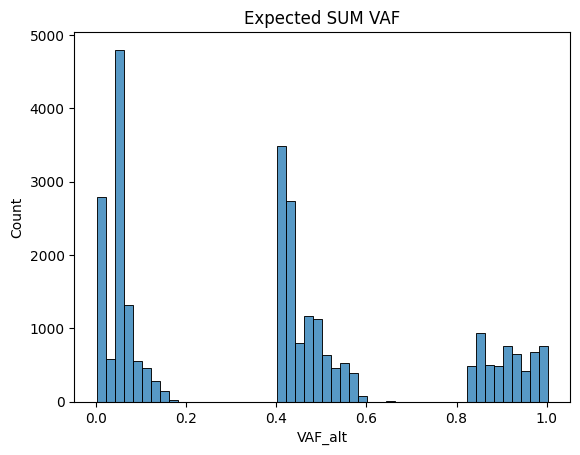

In [215]:
p = sb.histplot(sum_vaf[sum_vaf < 1], binwidth=0.02)
_ = p.set(title="Expected SUM VAF")

# Correlation of predicted / observed VAF

In [217]:
filt_sum_vaf = sum_vaf[sum_vaf < 1]

In [221]:
comp_vars = comp[comp['comp_id'].isin(filt_sum_vaf.index)].set_index(['comp_id'])

In [230]:
filt_sum_vaf.sample(3)

comp_id
11262.0    0.0500
1865.0     0.0500
25363.0    0.4825
Name: VAF_alt, dtype: float32

In [222]:
comp_vars['expected_vaf'] = filt_sum_vaf

In [238]:
(comp_vars['predicted_vaf'] - comp_vars['expected_vaf']).describe().to_frame()

,0
count,28008.000000
mean,0.034792
std,0.151433
min,-0.951905
25%,-0.019604
50%,0.012472
75%,0.045909
max,0.997500


In [275]:
from scipy.stats import pearsonr
pearsonr(comp_vars['predicted_vaf'], comp_vars['expected_vaf'])

PearsonRResult(statistic=0.8933811064060624, pvalue=0.0)

0.024141653235794237

In [326]:
parts = []
mask = comp_vars['expected_vaf'] < 0.30
parts.append((comp_vars[mask]['predicted_vaf'] - comp_vars[mask]['expected_vaf']).describe().to_frame())
parts[-1].loc['PearsonR'] = pearsonr(comp_vars[mask]['predicted_vaf'], comp_vars[mask]['expected_vaf'])[0]
MSE = ((comp_vars[mask]['expected_vaf'] - comp_vars[mask]['predicted_vaf']) ** 2).sum()  / len(comp_vars[mask])
parts[-1].loc['MSE'] = MSE

mask = comp_vars['expected_vaf'].between(0.30, 0.70)
parts.append((comp_vars[mask]['predicted_vaf'] - comp_vars[mask]['expected_vaf']).describe().to_frame())
parts[-1].loc['PearsonR'] = pearsonr(comp_vars[mask]['predicted_vaf'], comp_vars[mask]['expected_vaf'])[0]
MSE = ((comp_vars[mask]['expected_vaf'] - comp_vars[mask]['predicted_vaf']) ** 2).sum()  / len(comp_vars[mask])
parts[-1].loc['MSE'] = MSE

mask = comp_vars['expected_vaf'] > 0.70
parts.append((comp_vars[mask]['predicted_vaf'] - comp_vars[mask]['expected_vaf']).describe().to_frame())
parts[-1].loc['PearsonR'] = pearsonr(comp_vars[mask]['predicted_vaf'], comp_vars[mask]['expected_vaf'])[0]
MSE = ((comp_vars[mask]['expected_vaf'] - comp_vars[mask]['predicted_vaf']) ** 2).sum()  / len(comp_vars[mask])
parts[-1].loc['MSE'] = MSE

vaf_report = pd.concat(parts, axis=1)
vaf_report.columns = ["Low VAF", "Medium VAF", "High VAF"]

vaf_report.loc[['count', 'mean', '50%', 'std', 'PearsonR', 'MSE']]

,Low VAF,Medium VAF,High VAF
count,10919.000000,11411.000000,5678.000000
mean,0.056684,0.041836,-0.021466
50%,0.021429,0.002500,-0.003496
std,0.141982,0.169909,0.110242
PearsonR,0.155296,0.336577,0.490296
MSE,0.023370,0.030617,0.012612


In [265]:
comp_vars['vaf_bin'] = pd.cut(comp_vars['expected_vaf'], bins=[0, 0.3, 0.7, 1], labels=["Low", "Medium", "High"])
comp_vars['VAF delta'] = comp_vars['predicted_vaf'] - comp_vars['expected_vaf']

/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1057: Futu

[Text(0.5, 1.0, 'Predicted - Expected VAF'), Text(0.5, 0, 'VAF ∆')]

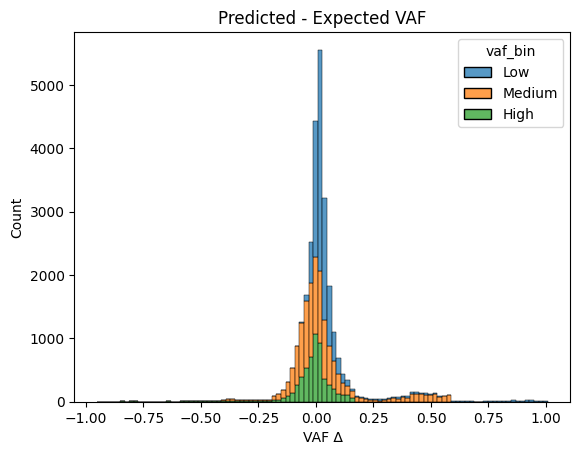

In [267]:
p = sb.histplot(data=comp_vars, x='VAF delta', binwidth=0.02, hue='vaf_bin', multiple='stack')
p.set(title="Predicted - Expected VAF", xlabel="VAF ∆")


/Users/english/py/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


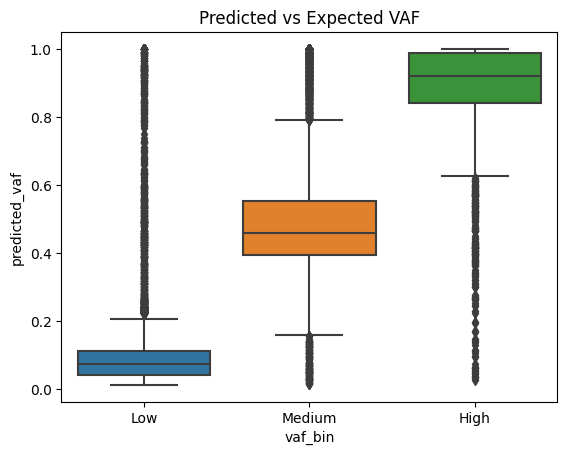

In [316]:
p = sb.boxplot(data=comp_vars, x='vaf_bin', y='predicted_vaf')
#sb.kdeplot(data=comp_vars, x="predicted_vaf", y="expected_vaf", hue="vaf_bin")
p.set(title="Predicted vs Expected VAF")
plt.legend().remove()


/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

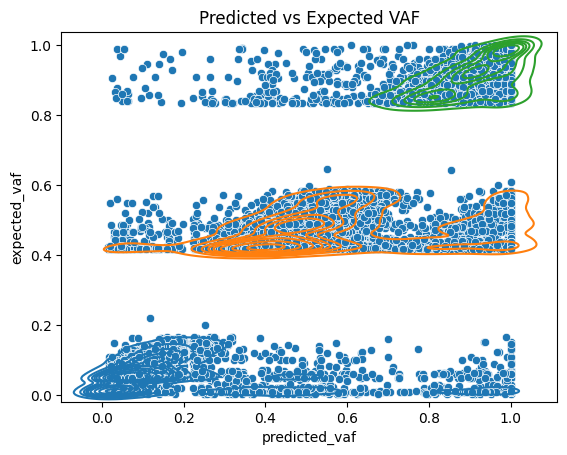

In [315]:
p = sb.scatterplot(data=comp_vars, x='predicted_vaf', y='expected_vaf')
sb.kdeplot(data=comp_vars, x="predicted_vaf", y="expected_vaf", hue="vaf_bin")
p.set(title="Predicted vs Expected VAF")
plt.legend().remove()


# Combined

Do we see better recall when we combine the ont and pacbio?
a.k.a. baseline consistency


In [15]:
combined = hifi_data[hifi_data['state'].isin(['tpbase', 'fn'])].join(
            ont_data[ont_data['state'].isin(['tpbase', 'fn'])], how='outer', lsuffix='_pac', rsuffix='_ont')



deno = pd.cut(base['VAF_alt'], bins=[0, 0.3, 0.7, 1], labels=["Low", "Medium", "High"]).value_counts()
deno.to_frame()

parts = []
always_missed = (combined[['state_pac', 'state_ont']] == 'fn').all(axis=1)
view = base[base.index.isin(combined[always_missed].index)]
x = pd.cut(view['VAF_alt'], bins=[0, 0.3, 0.7, 1], labels=["Low", "Medium", "High"]).value_counts()
parts.append(x.to_frame())

changed_state = combined['state_pac'] != combined['state_ont']
view = base[base.index.isin(combined[changed_state].index)]
x = pd.cut(view['VAF_alt'], bins=[0, 0.3, 0.7, 1], labels=["Low", "Medium", "High"]).value_counts()
parts.append(x.to_frame())

always_found = (combined[['state_pac', 'state_ont']] == 'tpbase').all(axis=1)
view = base[base.index.isin(combined[always_found].index)]
x = pd.cut(view['VAF_alt'], bins=[0, 0.3, 0.7, 1], labels=["Low", "Medium", "High"]).value_counts()
parts.append(x.to_frame())

view = pd.concat(parts, axis=1)
view.columns = ['FN', "F/T", "TP"]

In [10]:
combined[['state_pac', 'state_ont']].value_counts().unstack()

state_ont,fn,tpbase
state_pac,,
fn,46439,9106
tpbase,8154,42710


In [16]:
view

,FN,F/T,TP
VAF_alt,,,
Low,41719,14189,24141
Medium,4182,2743,13420
High,538,328,5149


In [1]:
import math
from scipy.stats import norm

def two_proportion_z_test(x1, n1, x2, n2):
    # Calculate the sample proportions
    p1 = x1 / n1
    p2 = x2 / n2
    
    # Calculate the pooled proportion
    p_pool = (x1 + x2) / (n1 + n2)
    
    # Calculate the standard error
    se = math.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    
    # Calculate the Z-score
    z = (p1 - p2) / se
    
    # Calculate the p-value for a two-tailed test
    p_value = 2 * (1 - norm.cdf(abs(z)))
    
    return z, p_value

low_count = 80049
low_switch = 14189
medium_count = 20345
medium_switch = 2743

two_proportion_z_test(low_switch, low_count, medium_switch, medium_count)

(14.432169328011105, 0.0)

In [21]:
view['TP'] / deno

VAF_alt
Low       0.301578
Medium    0.659622
High      0.856027
dtype: float64

,count
VAF_alt,
Low,14189
Medium,2743
High,328


In [ ]:
view['svtype'].value_counts()

svtype
INS    33377
DEL    13062
SNP        0
DUP        0
INV        0
NON        0
UNK        0
Name: count, dtype: int64

VAF_alt
Low       41719
Medium     4182
High        538
Name: count, dtype: int64

/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1057: Futu

<Axes: xlabel='VAF_alt', ylabel='Count'>

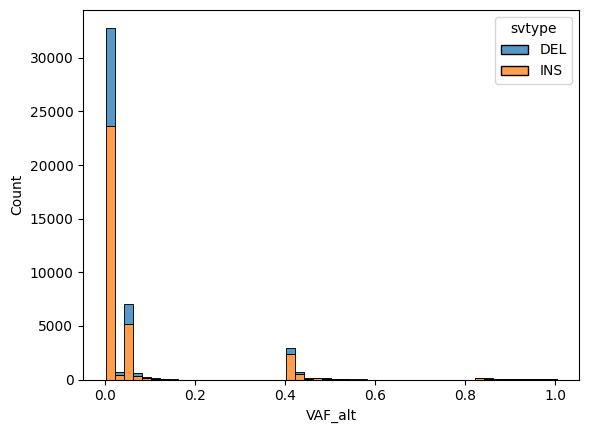

In [ ]:
sb.histplot(data=view, x="VAF_alt", hue='svtype', binwidth=0.02, multiple='stack', hue_order=['DEL', 'INS'])